Analysis code to reproduce Mei & Hime (2006) results. Put in your global path to the output of the GEANT4 simulation. Assumes you're using a 20m sidelength overburden cube with a 6m sidelength air cavity in the center. Also assumes the neutronTallyTree, primariesTree, and MINTree were enabled.

First step is opening tree, and getting some header information about the run

In [4]:
import numpy as np
import uproot as up
import matplotlib.pyplot as plt
#Open file
inpFilename = "merged.root"
inpFile = up.open(inpFilename)

#Get trees, can selectively load branches by passing in arrays=["names"] into arrays() call
headerTree = inpFile["headerTree"].arrays(library="np")
norm = headerTree["meiHimeFluxNormalization_per_cm2_per_s"][0]
nps = headerTree["nps"][0]

tallyTree = inpFile["neutronTallyTree"].arrays(library="np")
primariesTree = inpFile["primariesTree"].arrays(library="np")
MINTree = inpFile["MINTree"].arrays(library="np")

Load up Mei & Hime data here

In [2]:
plotMeiHime=1
xs=[]
ys=[]

if plotMeiHime==1:
    energyFile="meiHime/meiHimeEnergy.csv"
    distanceFile="meiHime/meiHimeDistance.csv"
    multiplicityFile="meiHime/meiHimeMultiplicity.csv"
    cosFile = "meiHime/meiHimeCos.csv"

    meiHimeFiles=[energyFile,distanceFile,multiplicityFile,cosFile]
    for meiHimeFile in meiHimeFiles:
        f = open(meiHimeFile,"r")
        xs.append([])
        ys.append([])
        for iline,line in enumerate(f):
            if iline==0:
                continue
            line=line.strip("\n")
            if line=="":
                continue
            lineParts=line.split(",")
            xs[-1].append(float(lineParts[0]))
            ys[-1].append(float(lineParts[1]))
        print("Total neutrons in {0} is {1:.3e}".format(meiHimeFile,sum(ys[-1])))
        f.close()

Total neutrons in meiHime/meiHimeEnergy.csv is 1.979e-11
Total neutrons in meiHime/meiHimeDistance.csv is 2.126e+00
Total neutrons in meiHime/meiHimeMultiplicity.csv is 2.037e-11
Total neutrons in meiHime/meiHimeCos.csv is 1.971e-11


First, compare neutron flux entering into the cavity with Mei & Hime (Table V), we compare the total neutron flux, flux > 1, 10, and 100 MeV. Mei & Hime apply the correction 0.64E_mu^0.02 - 0.74E_mu^-0.12 because FLUKA underpredicts the data--we ignore this. 


To normalize, we have to calculate the simulation time. This is the number of (thrown muons / throw area in cm2) / total flux from Mei & Hime, which we store in the header tree. 

In [5]:
worldArea = 2000 * 2000 #cm
nps_per_cm2 = float(nps) / worldArea
simTime = nps_per_cm2/norm 
timeScalingFactor = 1./simTime

applyMeiHimeCorrection = False #This is a FLUKA-specifc correction, FLUKA is ~35% too low

# Next we step through the number of neutrons in each bin
cutEnergies = [0,1,10,100] #MeV
nNeutrons = [0,0,0,0] #Tracks the number of neutrons in each of these bins
#Step through events
for entry in range(0,len(tallyTree["numNeutronsEntered"])):
    #Get event ID
    eventID = tallyTree["eventID"][entry]
    #Get the energy of the event in the primary tree with this event ID. Calculate correction factor
    idx = np.where(primariesTree["eventID"] == eventID)[0][0]
    muonEnergy_GeV = primariesTree["energy"][idx] / 1000.
    correctionFactor = 0.64*np.power(muonEnergy_GeV,0.02) - 0.74*np.power(muonEnergy_GeV,-0.12)
    #Calculate # of muons above each cut, applying correction factor
    for icut,cutEnergy in enumerate(cutEnergies):
        eventsAboveCut = [nrg for nrg in tallyTree["entry_energy"][entry] if nrg > cutEnergy]
        nAboveCut = len(eventsAboveCut)
        if applyMeiHimeCorrection:
             nAboveCut /= correctionFactor
        nNeutrons[icut] += nAboveCut

meiHimeVals=[0.054,0.02,0.018,0.005]
#Now we need to get the flux into neutrons/cm2/sec
cavityArea = 600 * 600 #cm
units_scaling = 1e-9 #Mei & Hime give the plot in units of 10^-9 n/cm2/sec
scaleFactor = timeScalingFactor / cavityArea
muonScaleFactor = nps / norm
for icut,cutEnergy in enumerate(cutEnergies):
    flux = nNeutrons[icut] * scaleFactor
    flux = flux / units_scaling
    print("GEANT4 Flux >{0} MeV is {1:.3f} x 10^-9 n/cm2/sec, Mei & Hime is {2:.3f} x 10^-9 n/cm2/sec".format(cutEnergy,flux,meiHimeVals[icut]))

GEANT4 Flux >0 MeV is 0.164 x 10^-9 n/cm2/sec, Mei & Hime is 0.054 x 10^-9 n/cm2/sec
GEANT4 Flux >1 MeV is 0.052 x 10^-9 n/cm2/sec, Mei & Hime is 0.020 x 10^-9 n/cm2/sec
GEANT4 Flux >10 MeV is 0.019 x 10^-9 n/cm2/sec, Mei & Hime is 0.018 x 10^-9 n/cm2/sec
GEANT4 Flux >100 MeV is 0.007 x 10^-9 n/cm2/sec, Mei & Hime is 0.005 x 10^-9 n/cm2/sec


Next, we plot the normalized energy spectrum (Fig. 17). Mei & Hime specifically mention this is the spectrum on neutrons emerging into the cavern. Mei & Hime presumably use counts/cm2/sec/bin size even though that's not labeled. They use 70 bins from 0 to 3.5 GeV.

Number of GEANT4 entries: 1.6426684417651983e-10
Number of Mei & Hime entries: 1.9786296050721007e-11
Scaling = 8.302051265958593


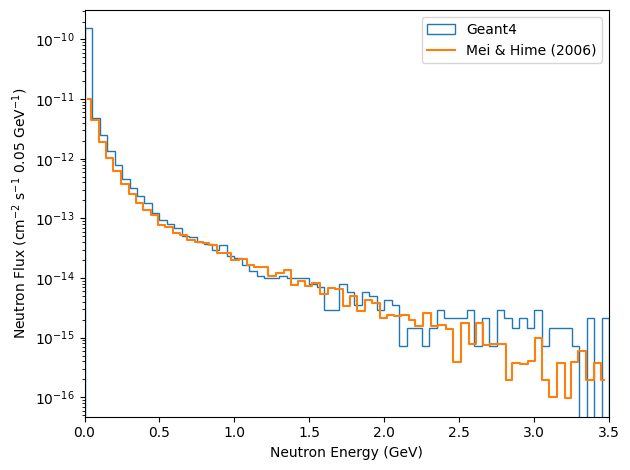

In [6]:
energies_MeV = np.concatenate(tallyTree["entry_energy"]) #Flatten the list of lists
energies_GeV = energies_MeV/1000.

weights = np.full_like(energies_GeV, scaleFactor)
print("Number of GEANT4 entries: {0}".format(np.sum(weights)))
print("Number of Mei & Hime entries: {0}".format(np.sum(ys[0])))
print("Scaling = {0}".format(np.sum(weights)/np.sum(ys[0])))

counts,bins,_ = plt.hist(energies_GeV, range=(0,3.5), bins=70, weights=weights, histtype="step", label = "Geant4")

if plotMeiHime==1:
    plt.plot(xs[0],ys[0],label="Mei & Hime (2006)",drawstyle='steps-mid')

plt.xlim(0, 3.5) #Set correct plot display range
plt.xlabel('Neutron Energy (GeV)')
plt.ylabel('Neutron Flux (cm$^{-2}$ s$^{-1}$ 0.05 GeV$^{-1}$)')
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("energy.png",dpi=350,bbox_inches="tight")
plt.show()

Next, we compare the angular distribution. Again, we assume Mei & Hime plot n/cm2/sec/0.02 cos theta

Number of GEANT4 entries: 1.6426684417651983e-10
Number of Mei & Hime entries: 1.97068578681346e-11
Scaling = 8.3355167665838


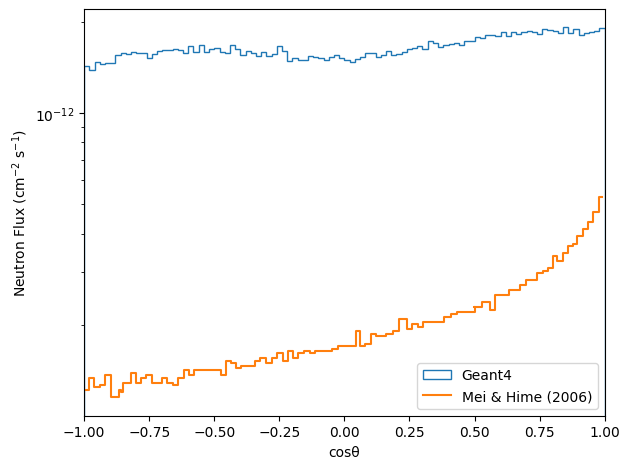

In [7]:
#angles = np.concatenate(MINTree["angleRelToMuon"]) #Flatten the list of lists
#cosTheta = np.cos(angles)
#weights = np.full_like(cosTheta, muonScaleFactor)

angles = np.concatenate(tallyTree["angleRelMuon"])
cosTheta = np.cos(angles)
weights = np.full_like(cosTheta, scaleFactor)

print("Number of GEANT4 entries: {0}".format(np.sum(weights)))
print("Number of Mei & Hime entries: {0}".format(np.sum(ys[3])))
print("Scaling = {0}".format(np.sum(weights)/np.sum(ys[3])))


plt.hist(cosTheta, bins=100, range = (-1,1), weights=weights, histtype="step",label="Geant4")

if plotMeiHime==1:
    plt.plot(xs[3],ys[3],label="Mei & Hime (2006)",drawstyle='steps-mid')
plt.xlim(-1,1) #Set correct plot display range
plt.xlabel('cos'+chr(952))
plt.ylabel('Neutron Flux (cm$^{-2}$ s$^{-1}$)')
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("costheta.png",dpi=350,bbox_inches="tight")
plt.show()



Next, we calculate the multiplicity of neutrons entering the cavern. Mei & Hime use multiplicity = 3 bins. Also, they do NOT apply the scale factor to correct FLUKA

Number of GEANT4 entries: 1.5273458453055237e-11
Number of Mei & Hime entries: 2.03726955926119e-11
Scaling = 0.7497023839395173


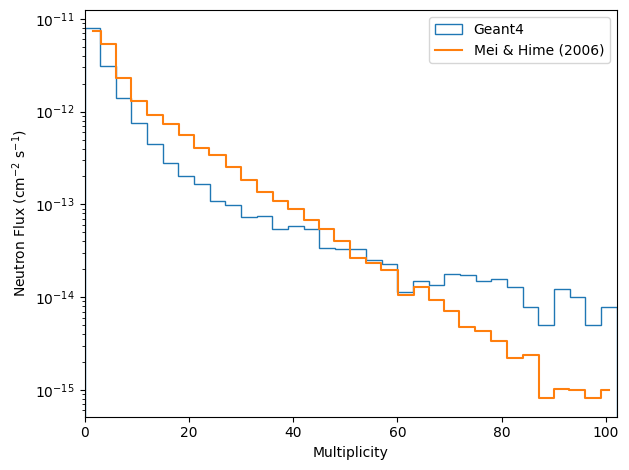

In [8]:
#multiplicities = MINTree["multiplicity"] #Flatten the list of lists
#multiplicities = multiplicities - 0.5 #Change to bin centers. 
#weights = np.full_like(multiplicities, muonScaleFactor)

multiplicities = tallyTree["numNeutronsEntered"] #Should already be flat
multiplicities = multiplicities - 0.5 #Change to bin centers. 
weights = np.full_like(multiplicities, scaleFactor)

print("Number of GEANT4 entries: {0}".format(np.sum(weights)))
print("Number of Mei & Hime entries: {0}".format(np.sum(ys[2])))
print("Scaling = {0}".format(np.sum(weights)/np.sum(ys[2])))

plt.hist(multiplicities, range=(0,102), bins=34, weights=weights, histtype="step",label="Geant4")

if plotMeiHime==1:
    plt.plot(xs[2],ys[2],label="Mei & Hime (2006)",drawstyle='steps-mid')
plt.xlim(0,102) #Set correct plot display range
plt.xlabel('Multiplicity')
plt.ylabel('Neutron Flux (cm$^{-2}$ s$^{-1}$)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("multiplicity.png",dpi=350,bbox_inches="tight")
plt.show()



Finally, we calculate the lateral distribution of neutrons from the primary. Because everything else was in terms of neutrons entering the cavern, we assume this is as well. They also normalize this differently, it's the fraction of the total # of neutrons as a specific distance.

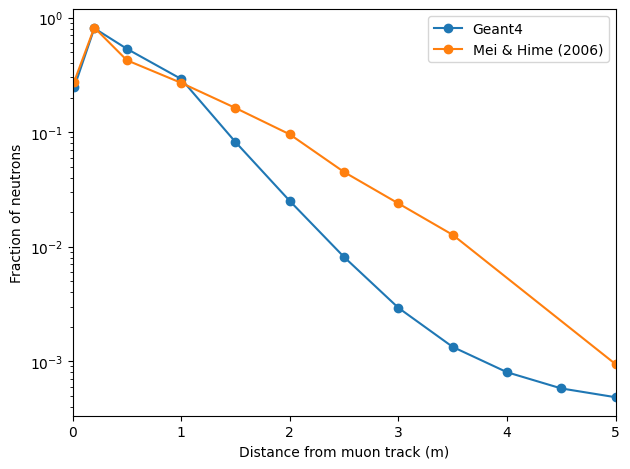

In [ ]:
#distances_mm = np.concatenate(tallyTree["distanceToMuonTrack"])
distances_mm = np.concatenate(MINTree["distanceToMuonTrack"])
distances_m = distances_mm / 1000

totalNeutrons = distances_m.size / 2 #Mei & Hime's adds to 2???
distances_to_eval = [0.015,0.2,0.5,1,1.5,2,2.50,3.0,3.5,4.0,4.5,5.0]
counts = []
for idist,dist in enumerate(distances_to_eval):
    if idist==0:
        mask = distances_m < dist
    else:
        mask = (distances_m < dist) & (distances_m >= distances_to_eval[idist-1])
    counts.append(distances_m[mask].size/totalNeutrons)

plt.plot(distances_to_eval,counts,label="Geant4",marker='o')

if plotMeiHime==1:
    plt.plot(xs[1],ys[1],label="Mei & Hime (2006)",marker='o')

plt.xlim(0,5) #Set correct plot display range
plt.xlabel('Distance from muon track (m)')
plt.ylabel('Fraction of neutrons')
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.savefig("distance.png",dpi=350,bbox_inches="tight")
plt.show()
